# Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import os
import pandas as pd
import numpy as np
import random
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import random
import torch
import torchvision
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
print(f'Using {"gpu" if device == "cuda" else "cpu"}')

Using cpu


# TensorFlow

In [ ]:
# Specifying relevant paths
WORKING_DIRECTORY = os.getcwd()
DEPENDENCIES = os.path.join(WORKING_DIRECTORY, 'dependencies')
MODELS = os.path.join(DEPENDENCIES, 'models')
TRAINING = os.path.join(DEPENDENCIES, 'cnn_data', 'training')


In [ ]:
# Generating image dataset from directory
img_height, img_width = 250, 250
train, val = tf.keras.utils.image_dataset_from_directory(
    TRAINING,
    labels='inferred',
    color_mode='rgb',
    seed=42,
    batch_size=32,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='both'
)

# class names
class_names = train.class_names


Found 3103 files belonging to 3 classes.
Using 2483 files for training.
Using 620 files for validation.


In [ ]:
print(f'Class names: {class_names}')


Class names: ['bicycle', 'car', 'person']


### Image Processing

In [ ]:
# We won't resize or rescale as that is the first layer of our nn

# Augmenting images with flipping and rotation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Apply augmentation
train_aug = train.map(lambda x, y: (data_augmentation(x), y))
val_aug = val.map(lambda x, y: (data_augmentation(x), y))

# Concattenate normal images and augmented ones
train_concat = train.concatenate(train_aug)
val_concat = val.concatenate(val_aug)

# Shuffle images
train_concat = train_concat.shuffle(buffer_size=10)
val_concat = val_concat.shuffle(buffer_size=10)


In [ ]:
# Print batch size and image size
for image_batch, labels_batch in val_concat:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 250, 250, 3)
(32,)


### CNN Based on Tiny VGG (From CNN Explainer)

In [ ]:
vgg = keras.Sequential([
    layers.Resizing(125,125),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(64, 3, strides=2, padding="same"), # conv_1_1
    layers.Activation("relu"), # relu_1_1
    layers.Conv2D(64, 3, strides=2, padding="same"), # conv_1_2
    layers.Activation("relu"), # relu_1_2
    layers.MaxPool2D(3, strides = 2, padding="same"), # max_pool_1
    layers.Conv2D(64, 3, strides=2, padding="same"), # conv_2_1
    layers.Activation("relu"), # relu_2_1
    layers.Conv2D(64, 3, strides=2, padding="same"), # conv_2_2
    layers.Activation("relu"), # relu_2_2
    layers.MaxPool2D(3, strides = 2, padding="same"), # max_pool_2
    layers.Conv2D(64, 3, strides=2, padding="same"), # conv_3_1
    layers.Activation("relu"), # relu_3_1
    layers.Conv2D(64, 3, strides=2, padding="same"), # conv_3_2
    layers.Activation("relu"), # relu_3_2
    layers.MaxPool2D(3, strides = 2, padding="same"), # max_pool_3
    layers.Flatten(),
    layers.Dense(3, activation='softmax')    
])

In [ ]:
# Compiling model using sgd optimizer, cross entropy as loss and accuracy metric
vgg.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Add callbacks with early stopping if after 10 epochs nothing change + reducing lr with 0.1 after 5 epochs if nothing improves
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
             keras.callbacks.ModelCheckpoint("vgg_{epoch}.keras", save_freq=5),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)]

In [ ]:
# Training model using 100 epochs (batch size is 32)
epochs = 100

vgg_history = vgg.fit(train_concat,
                      epochs=epochs,
                      callbacks=callbacks,
                      validation_data=val_concat)

Epoch 1/100
156/156 [==============================] - 102s 638ms/step - loss: 1.0943 - accuracy: 0.3743 - val_loss: 1.0867 - val_accuracy: 0.3565 - lr: 0.1000
Epoch 2/100
156/156 [==============================] - 96s 610ms/step - loss: 1.0706 - accuracy: 0.4394 - val_loss: 1.0088 - val_accuracy: 0.5097 - lr: 0.1000
Epoch 3/100
156/156 [==============================] - 86s 544ms/step - loss: 1.0205 - accuracy: 0.4942 - val_loss: 0.9872 - val_accuracy: 0.5218 - lr: 0.1000
Epoch 4/100
156/156 [==============================] - 86s 544ms/step - loss: 0.9867 - accuracy: 0.5332 - val_loss: 1.0429 - val_accuracy: 0.4306 - lr: 0.1000
Epoch 5/100
156/156 [==============================] - 96s 609ms/step - loss: 0.9115 - accuracy: 0.5902 - val_loss: 1.0169 - val_accuracy: 0.5427 - lr: 0.1000
Epoch 6/100
156/156 [==============================] - 85s 536ms/step - loss: 0.8649 - accuracy: 0.6136 - val_loss: 0.8313 - val_accuracy: 0.6427 - lr: 0.1000
Epoch 7/100
156/156 [========================

In [ ]:
version = 'xxx'
vgg.save(f'{MODELS}/TinyVGG_Model_v{version}.keras')

### Keras's small version of Xception network

In [ ]:
# Inspired by keras smaller version of the XCeption network
def XceptionModel(input_shape=(250,250,3), num_of_classes=3):
  
  # Input layer of model
  input_layer = keras.Input(shape=input_shape)

  # Added rescaling and resizing to input
  lay = layers.Resizing(125,125)(input_layer)
  lay = layers.Rescaling(1.0 / 255)(lay)

  # First con-block
  lay = layers.Conv2D(128, 3, strides=2, padding="same")(lay)
  lay = layers.BatchNormalization()(lay)
  lay = layers.Activation("relu")(lay)

  previous_residuals = lay
  
  # Mid layer - three iterations using various filter sizes
  for filter in [128, 256, 512]:
    lay = layers.Activation("relu")(lay)
    lay = layers.SeparableConv2D(filter, 3, padding="same")(lay)
    lay = layers.BatchNormalization()(lay)
    lay = layers.Activation("relu")(lay)
    lay = layers.SeparableConv2D(filter, 3, padding="same")(lay)
    lay = layers.BatchNormalization()(lay)
    lay = layers.MaxPooling2D(3, strides = 2, padding="same")(lay)

    residual = layers.Conv2D(filter, 1, strides=2, padding="same")(previous_residuals)
  
    # Skip connection
    lay = layers.add([lay, residual])
    previous_residuals = lay

  # FInal layer
  lay = layers.SeparableConv2D(1024, 3, padding="same")(lay)
  lay = layers.BatchNormalization()(lay)
  lay = layers.Activation("relu")(lay)

  lay = layers.GlobalAveragePooling2D()(lay)
  lay = layers.Dropout(0.5)(lay)
  outputs = layers.Dense(num_of_classes, activation='softmax')(lay)

  return keras.Model(input_layer, outputs)

In [ ]:
Xception = XceptionModel()

In [ ]:
epochs = 100

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras", save_freq=5),
             keras.callbacks.EarlyStopping(monitor='loss', patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
]

Xception.compile(
    optimizer=keras.optimizers.SGD(0.1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

Xception_history = Xception.fit(train_concat,
                                epochs=epochs,
                                callbacks=callbacks,
                                validation_data=val_concat)

Epoch 1/100
156/156 [==============================] - 50s 284ms/step - loss: 1.5336 - accuracy: 0.5588 - val_loss: 1.0970 - val_accuracy: 0.3766 - lr: 0.1000
Epoch 2/100
156/156 [==============================] - 43s 269ms/step - loss: 0.9106 - accuracy: 0.6683 - val_loss: 1.1713 - val_accuracy: 0.3556 - lr: 0.1000
Epoch 3/100
156/156 [==============================] - 43s 269ms/step - loss: 0.8376 - accuracy: 0.6867 - val_loss: 1.0425 - val_accuracy: 0.5250 - lr: 0.1000
Epoch 4/100
156/156 [==============================] - 42s 267ms/step - loss: 0.7753 - accuracy: 0.7135 - val_loss: 1.1401 - val_accuracy: 0.4895 - lr: 0.1000
Epoch 5/100
156/156 [==============================] - 45s 286ms/step - loss: 0.7122 - accuracy: 0.7265 - val_loss: 1.1763 - val_accuracy: 0.6169 - lr: 0.1000
Epoch 6/100
156/156 [==============================] - 42s 267ms/step - loss: 0.6604 - accuracy: 0.7471 - val_loss: 0.7083 - val_accuracy: 0.7548 - lr: 0.1000
Epoch 7/100
156/156 [=========================

In [ ]:
Xception.save(f'{image_folder}/Xception_model_{version}.keras')

## Plotting Results

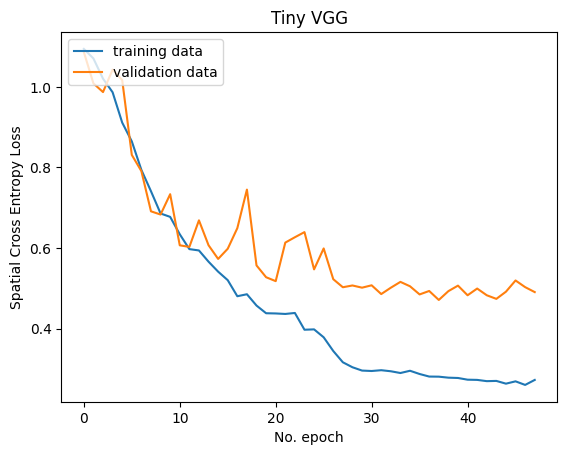

In [ ]:
# Plot history:
plt.plot(vgg_history.history['loss'], label='training data')
plt.plot(vgg_history.history['val_loss'], label='validation data')
plt.ylabel('Spatial Cross Entropy Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Tiny VGG')
plt.show()

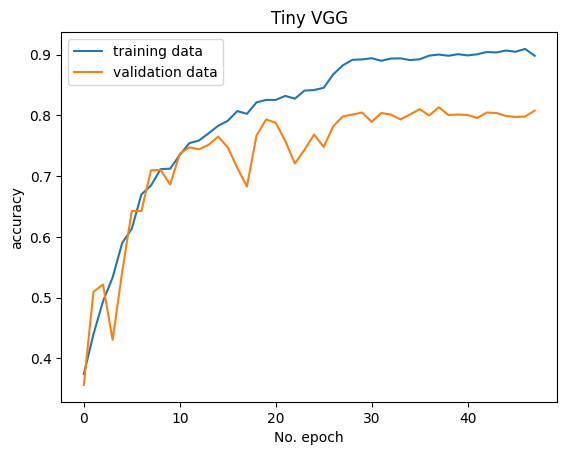

In [ ]:
# Plot history:
plt.plot(vgg_history.history['accuracy'], label='training data')
plt.plot(vgg_history.history['val_accuracy'], label='validation data')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Tiny VGG')
plt.show()

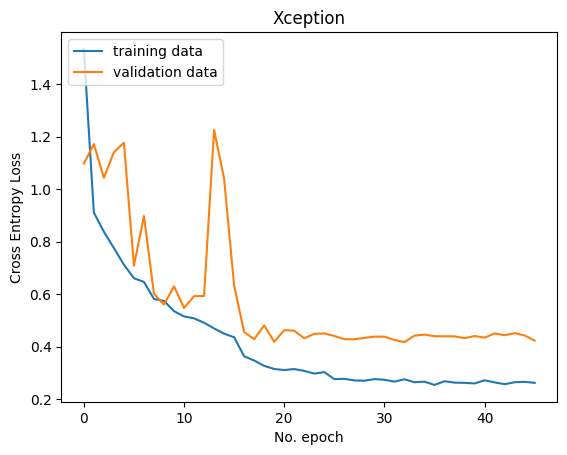

In [ ]:
# Plot history:
plt.plot(Xception_history.history['loss'], label='training data')
plt.plot(Xception_history.history['val_loss'], label='validation data')
plt.ylabel('Spatial Cross Entropy Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Xception')
plt.show()

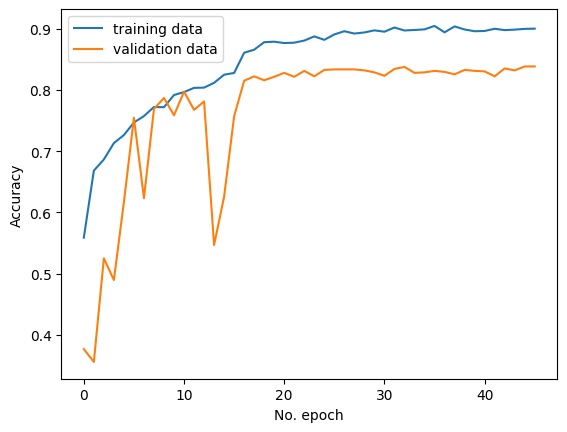

In [ ]:
# Plot history:
plt.plot(Xception_history.history['accuracy'], label='training data')
plt.plot(Xception_history.history['val_accuracy'], label='validation data')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Xception')
plt.show()